# Machine Learning project

This project aims to predict the sale price of residential properties using various intrinsic and contextual features such as living area, number of rooms, year built, overall quality, and neighborhood.
Using the Ames Housing Dataset, the task is framed as a supervised regression problem, where the target variable is the house sale price.
Data preprocessing includes handling missing values, encoding categorical variables, and removing outliers.
Several machine learning models were compared — from Linear Regression to Random Forest and Gradient Boosting (XGBoost, LightGBM) — with performance evaluated using metrics such as MAE, RMSE, and R².
The goal is to build an interpretable and accurate model capable of generalizing well to unseen data, while providing insights into the most influential factors affecting housing prices.

## 1. Data Collection and Preparation

### 1.1. Import dataset

In [79]:
import pandas as pd
import numpy as np

In [80]:
data_path = "C:/Users/augus/OneDrive - De Vinci/Cours_Esilv/S7/Machine Learning/Project/train.csv"

In [81]:
data = pd.read_csv(data_path)

In [82]:
data.shape

(1460, 81)

In [83]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1.2. Data Cleaning and Processing

In [84]:
from sklearn.impute import SimpleImputer

# Numerical and categorical columns
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# Columns with missing values
num_missing = [col for col in num_features if data[col].isnull().sum() > 0]
cat_missing = [col for col in cat_features if data[col].isnull().sum() > 0]

# Imputation
num_imp = SimpleImputer(strategy='median')
data[num_missing] = num_imp.fit_transform(data[num_missing])

cat_imp = SimpleImputer(strategy='most_frequent')
data[cat_missing] = cat_imp.fit_transform(data[cat_missing])

# Verification
print("Total number of missing values after imputation:", data.isnull().sum().sum())

Total number of missing values after imputation: 0


In [85]:
# Identify categorical columns
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# One-Hot Encoding with pandas
data_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)

# Verification
print("New dimensions after encoding:", data_encoded.shape)

New dimensions after encoding: (1460, 246)


In [86]:
data_encoded.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,False,True,False,False,False,True,False


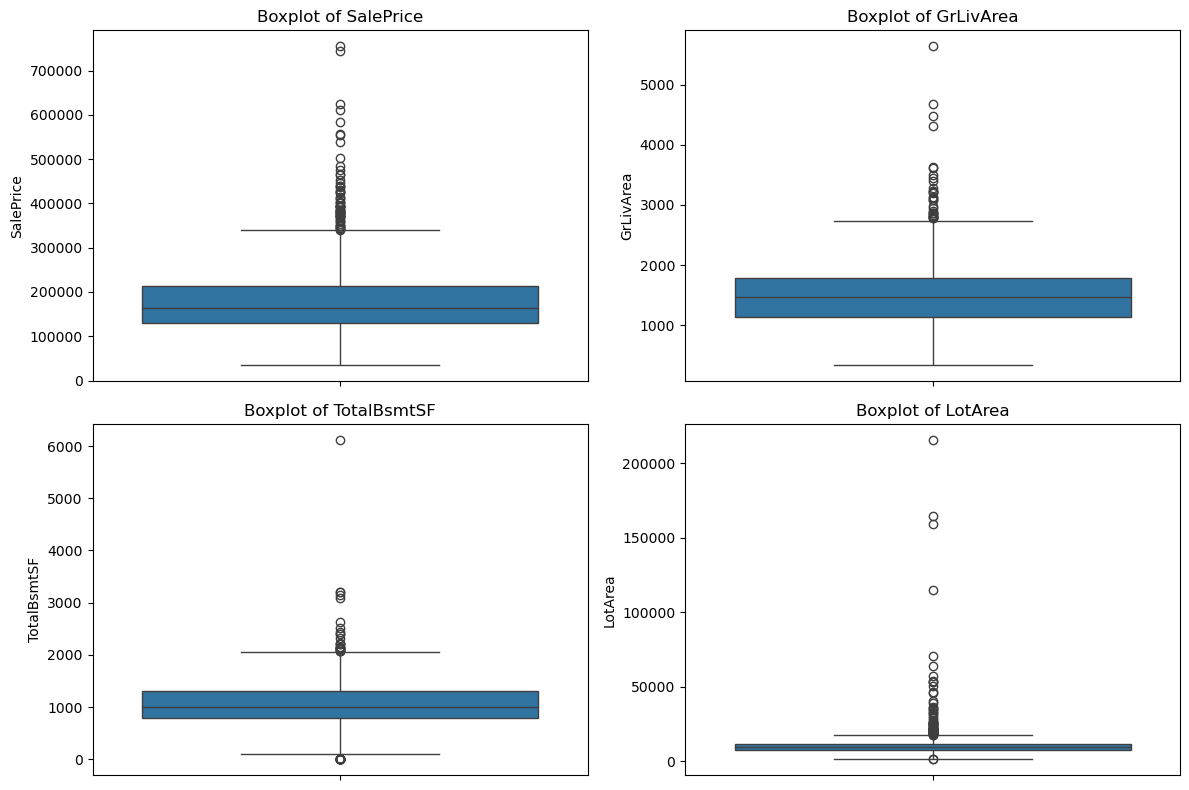

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Important numerical columns
cols_num = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'LotArea']

# Figure size
plt.figure(figsize=(12, 8))

# Loop to create a boxplot for each column
for i, col in enumerate(cols_num, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data_encoded[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [88]:
# Important numerical columns to detect outliers
cols_num = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'LotArea']

# Removing outliers using the IQR method
for col in cols_num:
    Q1 = data_encoded[col].quantile(0.25)
    Q3 = data_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data_encoded = data_encoded[(data_encoded[col] >= lower_bound) & (data_encoded[col] <= upper_bound)]

print("Dimensions after removing outliers:", data_encoded.shape)

Dimensions after removing outliers: (1261, 246)


### 1.3. Feature engineering

In [89]:
# Compute the age of the house
data_encoded['AgeHouse'] = data_encoded['YrSold'] - data_encoded['YearBuilt']

# Compute the years since the last remodel
data_encoded['AgeRemod'] = data_encoded['YrSold'] - data_encoded['YearRemodAdd']

# Compute total square footage
data_encoded['TotalSF'] = (
    data_encoded['TotalBsmtSF'] +
    data_encoded['1stFlrSF'] +
    data_encoded['2ndFlrSF']
)

# Compute total number of bathrooms
data_encoded['Bathrooms'] = (
    data_encoded['FullBath'] +
    0.5 * data_encoded['HalfBath'] +
    data_encoded['BsmtFullBath'] +
    0.5 * data_encoded['BsmtHalfBath']
)

# Compute living area to lot area ratio
data_encoded['LivingRatio'] = data_encoded['GrLivArea'] / data_encoded['LotArea']

In [90]:
# Compute number of rooms per square foot of living area
data_encoded['RoomPerArea'] = data_encoded['TotRmsAbvGrd'] / data_encoded['GrLivArea']

# Compute overall quality weighted by living area
data_encoded['QualityPerArea'] = data_encoded['OverallQual'] * data_encoded['GrLivArea']

# Compute basement area ratio
data_encoded['BasementRatio'] = data_encoded['TotalBsmtSF'] / data_encoded['TotalSF']

In [91]:
data_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
data_encoded.fillna(0, inplace=True)

In [92]:
print(data_encoded.shape)
data_encoded.head()

(1261, 254)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition_Normal,SaleCondition_Partial,AgeHouse,AgeRemod,TotalSF,Bathrooms,LivingRatio,RoomPerArea,QualityPerArea,BasementRatio
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,True,False,5,5,2566,3.5,0.202367,0.004678,11970,0.333593
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,True,False,31,31,2524,2.5,0.131458,0.004754,7572,0.500000
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,True,False,7,6,2706,3.5,0.158756,0.003359,12502,0.339985
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,91,36,2473,2.0,0.179791,0.004077,12019,0.305702
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,True,False,8,8,3343,3.5,0.154137,0.004095,17584,0.342507


## 2. Exploratory Data Analysis (EDA)

In [93]:
print(data_encoded.info())
data_encoded.describe().T.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1261 entries, 0 to 1459
Columns: 254 entries, Id to BasementRatio
dtypes: bool(208), float64(7), int64(39)
memory usage: 719.2 KB
None


,count,mean,std,min,25%,50%,75%,max
Id,1261.0,728.443299,422.409031,1.0,366.0,733.0,1095.0,1460.0
MSSubClass,1261.0,57.287867,42.330657,20.0,20.0,50.0,70.0,190.0
LotFrontage,1261.0,67.893735,18.325231,21.0,60.0,69.0,76.0,182.0
LotArea,1261.0,9043.674068,3043.499110,1680.0,7313.0,9120.0,10927.0,16905.0
OverallQual,1261.0,6.013481,1.242364,1.0,5.0,6.0,7.0,10.0
OverallCond,1261.0,5.600317,1.094923,1.0,5.0,5.0,6.0,9.0
YearBuilt,1261.0,1970.824742,30.393272,1872.0,1953.0,1972.0,2000.0,2009.0
YearRemodAdd,1261.0,1984.662966,20.577453,1950.0,1966.0,1993.0,2003.0,2010.0
MasVnrArea,1261.0,89.118953,156.096648,0.0,0.0,0.0,144.0,1600.0
BsmtFinSF1,1261.0,411.239492,392.337597,0.0,0.0,377.0,680.0,1619.0


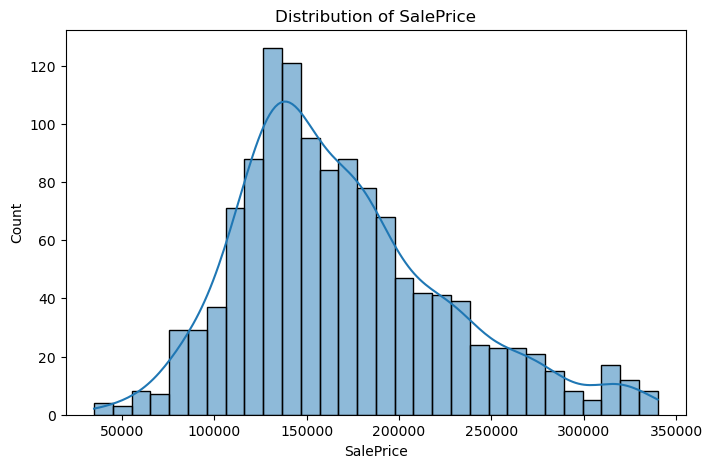

Skewness: 0.7300837780787952


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8,5))
sns.histplot(data_encoded['SalePrice'], kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.show()

# Check skewness
print("Skewness:", data_encoded['SalePrice'].skew())

SalePrice           1.000000
QualityPerArea      0.840450
OverallQual         0.796603
TotalSF             0.788926
GrLivArea           0.680625
GarageCars          0.648331
GarageArea          0.633570
YearBuilt           0.623662
Bathrooms           0.623146
ExterQual_Gd        0.599788
FullBath            0.592460
TotalBsmtSF         0.570090
Foundation_PConc    0.565651
YearRemodAdd        0.564450
1stFlrSF            0.541882
GarageYrBlt         0.528724
KitchenQual_Gd      0.481282
TotRmsAbvGrd        0.458059
BsmtFinType1_GLQ    0.436838
BsmtQual_Gd         0.420683
Name: SalePrice, dtype: float64


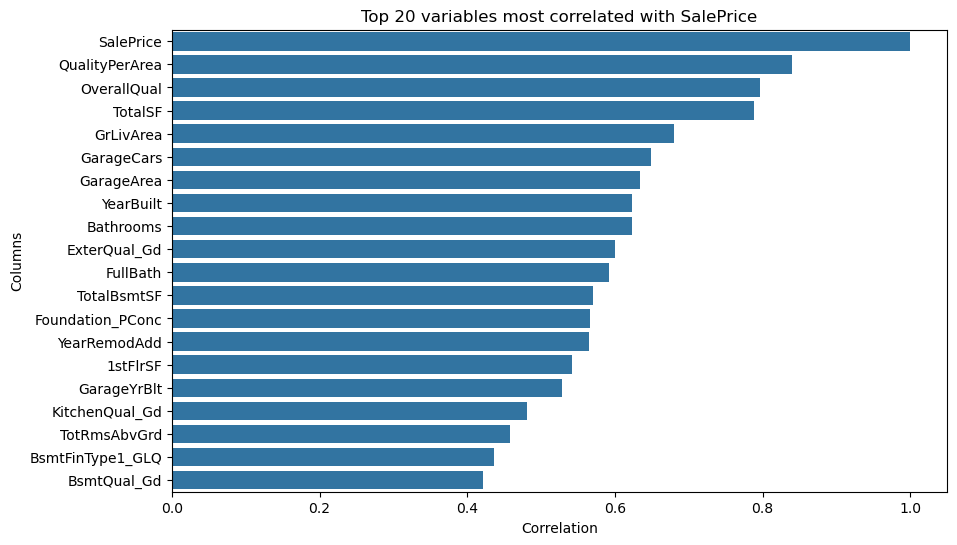

In [95]:
corr_matrix = data_encoded.corr(numeric_only=True)

# Top 20 variables most correlated with the price
top_corr = corr_matrix['SalePrice'].sort_values(ascending=False).head(20)
print(top_corr)

plt.figure(figsize=(10,6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 20 variables most correlated with SalePrice")
plt.xlabel("Correlation")
plt.ylabel("Columns")
plt.show()

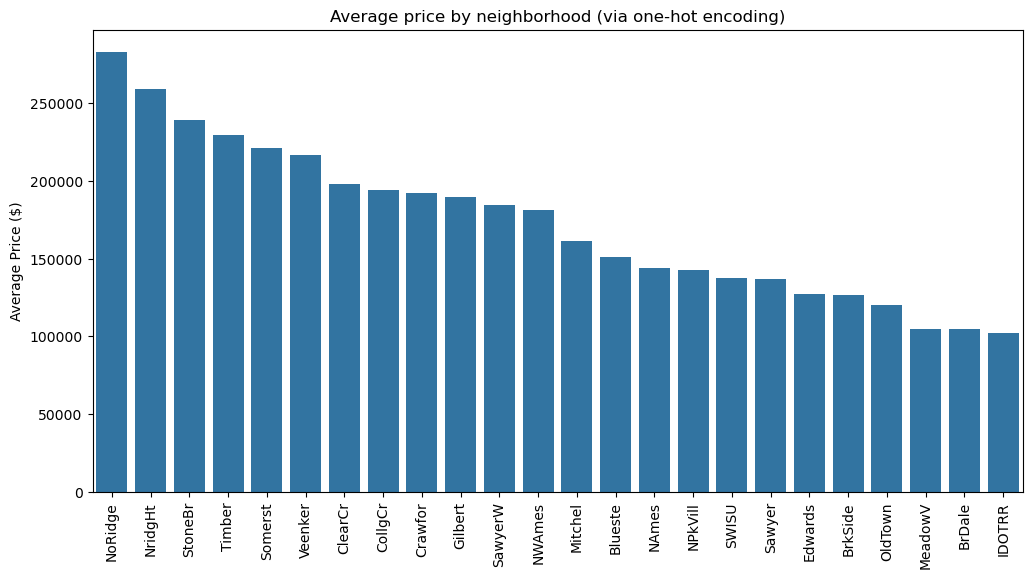

In [96]:
neighborhood_cols = [col for col in data_encoded.columns if col.startswith('Neighborhood_')]

# Average price by neighborhood (using encoded columns)
mean_prices = {}
for col in neighborhood_cols:
    mean_prices[col.replace('Neighborhood_', '')] = data_encoded.loc[data_encoded[col]==1, 'SalePrice'].mean()

mean_prices = dict(sorted(mean_prices.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12,6))
sns.barplot(x=list(mean_prices.keys()), y=list(mean_prices.values()))
plt.xticks(rotation=90)
plt.title("Average price by neighborhood (via one-hot encoding)")
plt.ylabel("Average Price ($)")
plt.show()

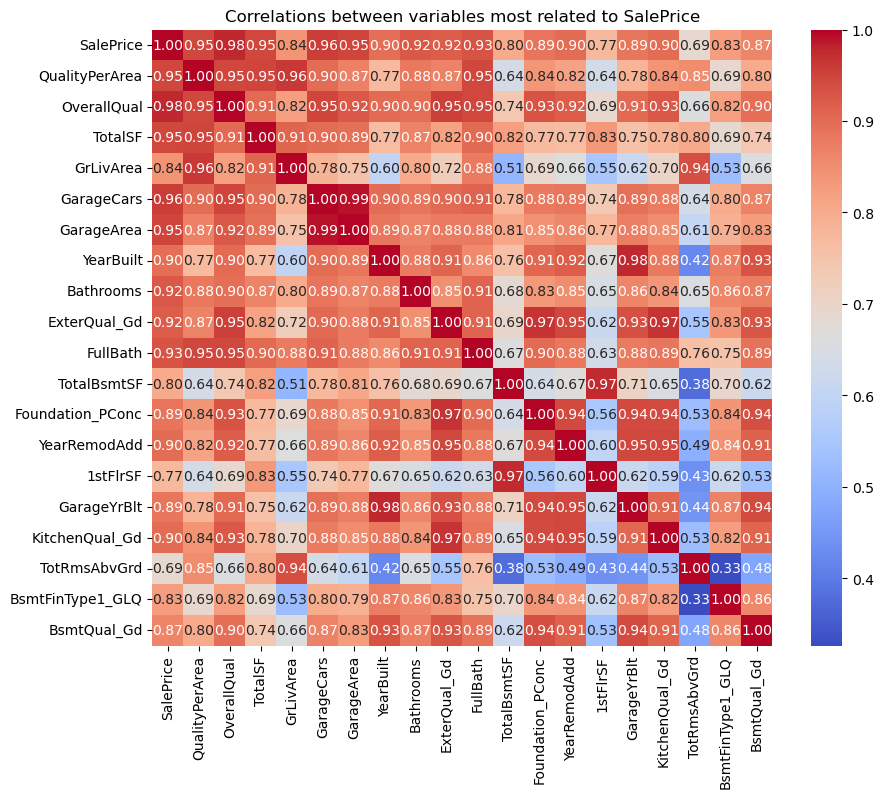

In [97]:
# Display heatmap of the 20 variables most correlated with the price
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix[top_corr.index].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlations between variables most related to SalePrice")
plt.show()

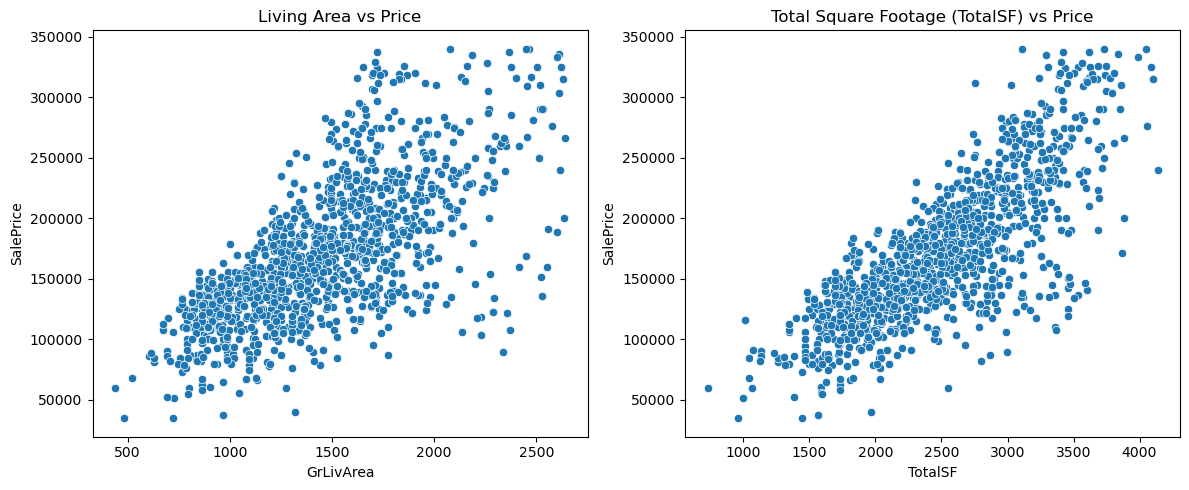

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Scatter plot: Living area vs SalePrice
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data_encoded, ax=axes[0])
axes[0].set_title("Living Area vs Price")

# Scatter plot: Total square footage vs SalePrice
sns.scatterplot(x='TotalSF', y='SalePrice', data=data_encoded, ax=axes[1])
axes[1].set_title("Total Square Footage (TotalSF) vs Price")

plt.tight_layout()
plt.show()

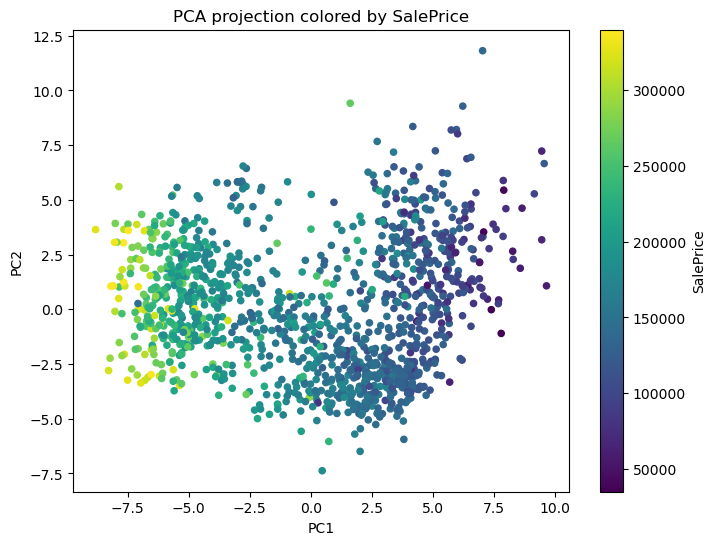

In [99]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
X_scaled = StandardScaler().fit_transform(data_encoded.drop(columns=['SalePrice'], errors='ignore'))

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Scatter plot of the first two principal components colored by SalePrice
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1],
            c=data_encoded['SalePrice'], cmap='viridis', s=20)
plt.colorbar(label='SalePrice')
plt.title("PCA projection colored by SalePrice")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 3. Modeling

### 3.1. Data Splitting

In [100]:
from sklearn.model_selection import train_test_split

# Splitting X / y
X = data_encoded.drop(columns=['SalePrice'], errors='ignore')
y = data_encoded['SalePrice']

# Split 80 / 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set : {X_train.shape}")
print(f"Test set  : {X_test.shape}")

Train set : (1008, 253)
Test set  : (253, 253)


### 3.2. Model Comparison

In [101]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define models to compare
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
    )
}

results = {}

# Train each model and evaluate performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

# Display results sorted by RMSE
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\nComparative Results:")
display(results_df)

C:\Users\augus\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.338e+10, tolerance: 3.284e+08
  model = cd_fast.enet_coordinate_descent(



Comparative Results:


,MAE,RMSE,R2
Ridge,11510.851044,16403.422605,0.913333
Lasso,11979.743091,17084.399555,0.905988
LinearRegression,11985.033689,17091.597618,0.905909
RandomForest,13048.843040,17349.292636,0.903050


### 3.3. Optimisation

In [102]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2
)

# Fit GridSearchCV
grid_rf.fit(X_train, y_train)

print("\nBest hyperparameters:", grid_rf.best_params_)

# Get the best estimator
best_rf = grid_rf.best_estimator_

# Evaluate on the test set
y_pred_rf = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"\nOptimized RandomForest Performance:")
print(f"RMSE = {rmse:.2f}")
print(f"MAE  = {mae:.2f}")
print(f"R²   = {r2:.3f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_es

### 3.4. Overfittinf/underfitting

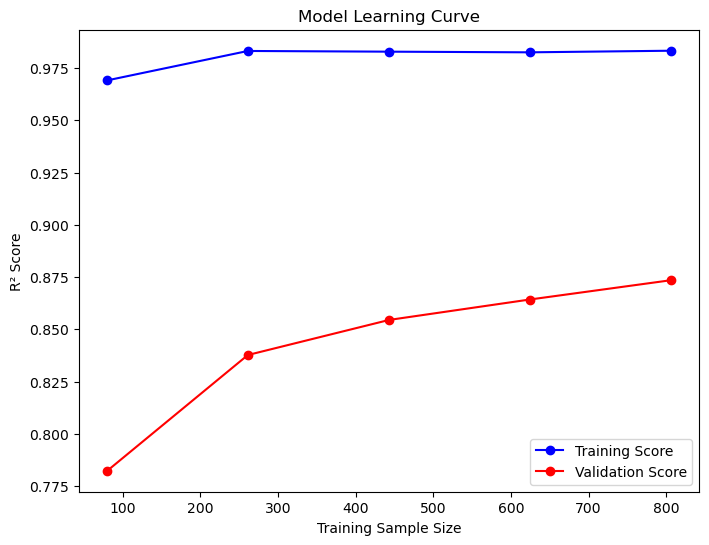

In [103]:
from sklearn.model_selection import learning_curve

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Compute mean scores across folds
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
# Plot training and validation scores
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Validation Score")
plt.xlabel("Training Sample Size")
plt.ylabel("R² Score")
plt.title("Model Learning Curve")
plt.legend()
plt.show()

### 3.5. Evaluation

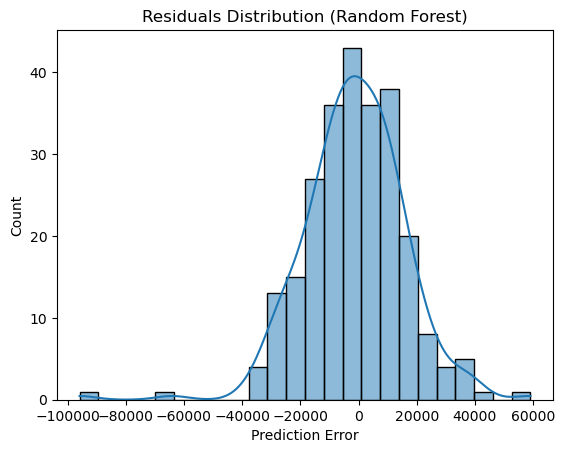

In [104]:
# Compute residuals
residuals = y_test - y_pred_rf

# Plot distribution of residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Prediction Error")
plt.show()

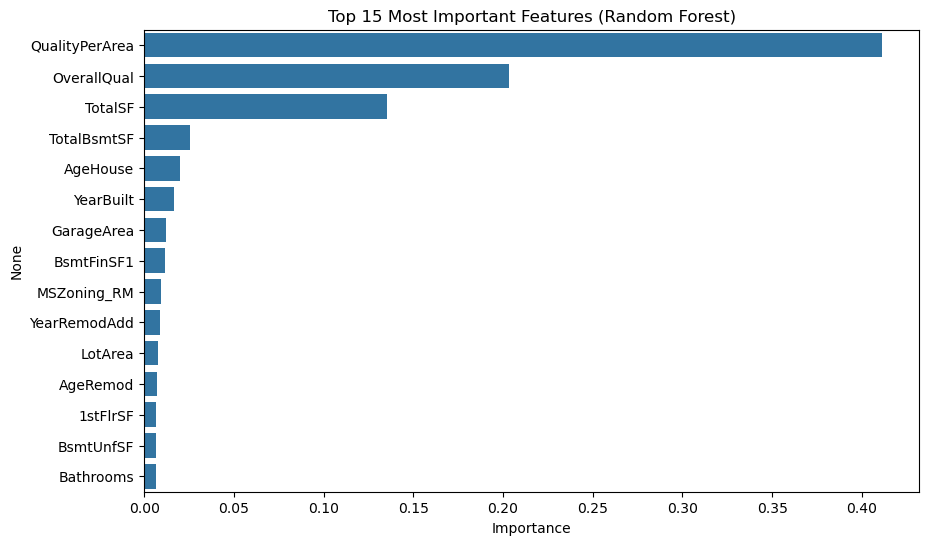

In [105]:
# Feature importances from the best Random Forest
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

# Plot top 15 most important features
plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Importance")
plt.show()

To evaluate the quality of regression models used for predicting house sale prices, several metrics are calculated to measure the accuracy and robustness of predictions. MAE (Mean Absolute Error) corresponds to the average absolute difference between predicted and actual values. It indicates, on average, by how much the model is wrong, without considering the direction of the error. A low MAE means the model makes few errors, which makes it easier to interpret in practice.

RMSE (Root Mean Squared Error) penalizes large errors more heavily. Indeed, deviations are first squared before being averaged, and then the square root is taken. This metric is useful to detect whether the model occasionally makes large errors on some houses.

Finally, R² (coefficient of determination) measures the proportion of variance in the actual price explained by the model. Its value ranges from 0 to 1: the closer it is to 1, the more effectively the model explains price variations. A low R² indicates that the model does not capture well the relationships between house features and their sale price.

In summary, a good model has low MAE and RMSE, as well as a high R², ensuring both accuracy and consistency of predictions.

## 4. Interpretation and Visualization

### 4.1 Model interpretation

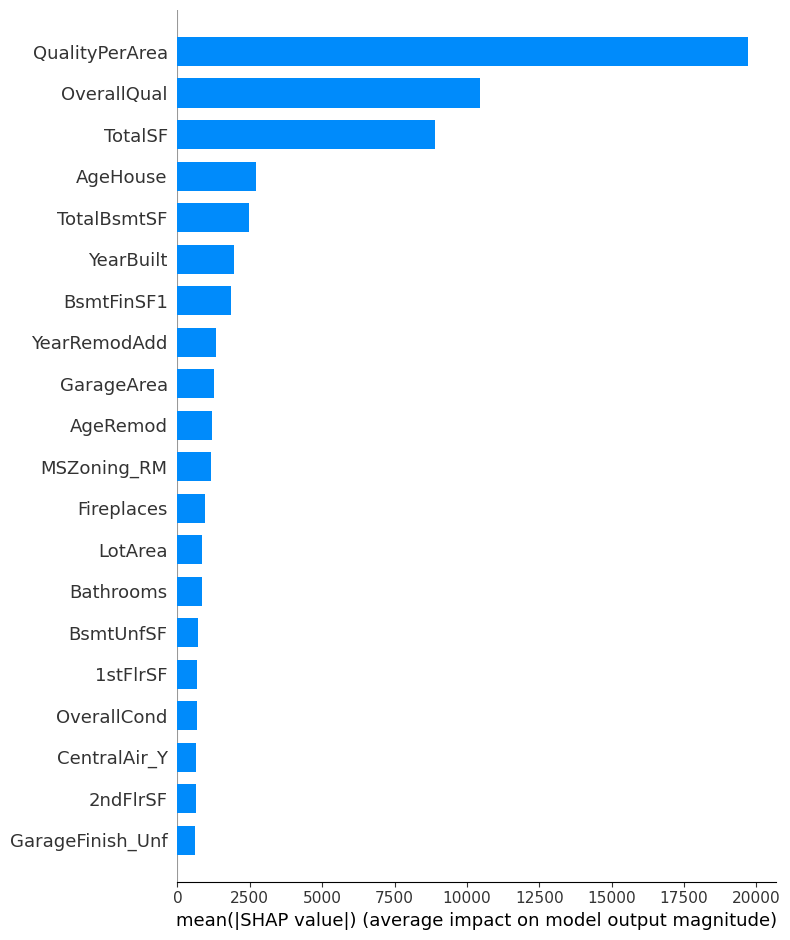

In [106]:
import shap

# Create an explainer based on the final model (e.g., RandomForest)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Global summary: average importance of each feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

### 4.2. Results visualization

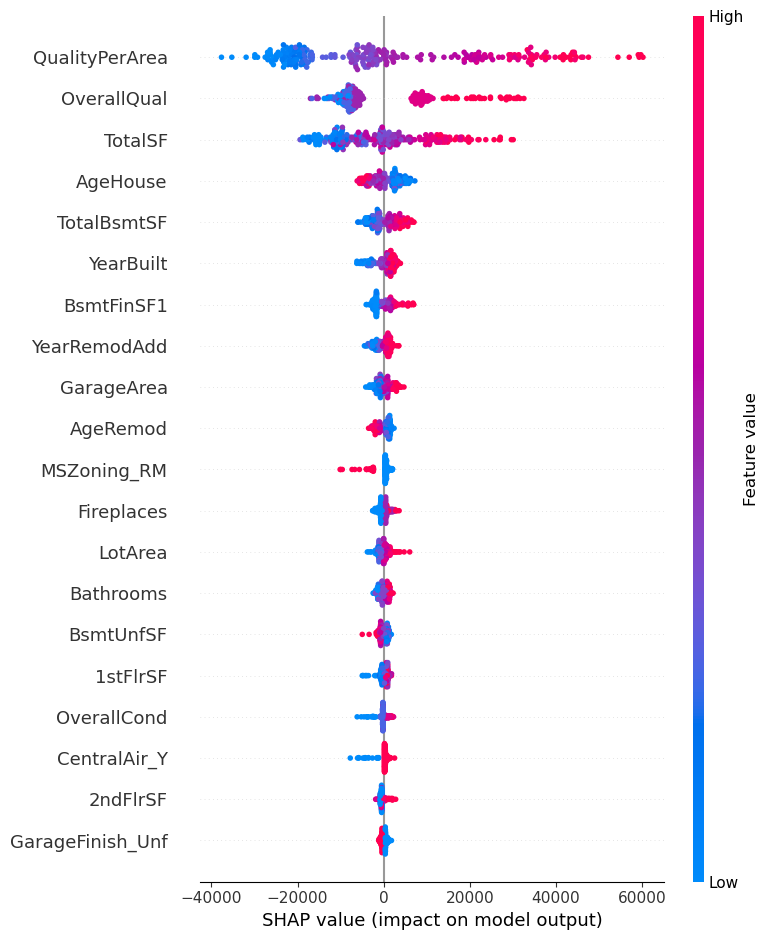

In [107]:
shap.summary_plot(shap_values, X_test)

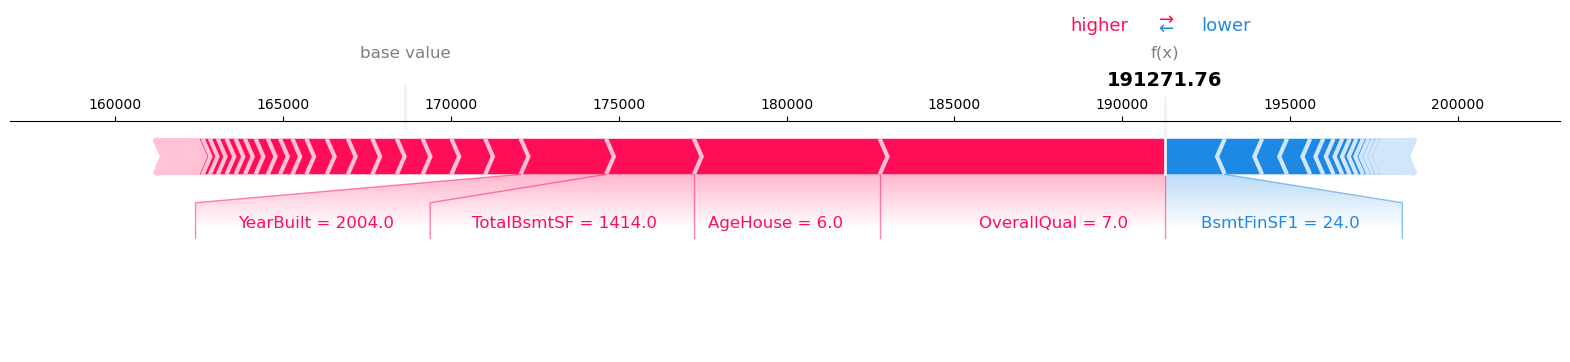

In [108]:
i = 0  # example : first house of the test
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_test.iloc[i, :],
    matplotlib=True
)

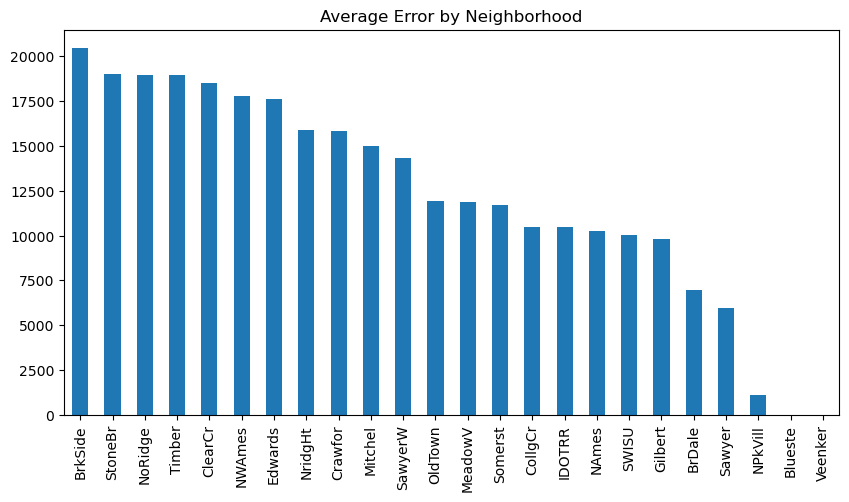

In [109]:
# Create a copy of X_test and add actual and predicted prices, as well as absolute errors
X_test_copy = X_test.copy()
X_test_copy['SalePrice'] = y_test
X_test_copy['Predicted'] = y_pred_rf
X_test_copy['Error'] = abs(X_test_copy['SalePrice'] - X_test_copy['Predicted'])

# Identify neighborhood columns
neighborhood_cols = [col for col in X_test_copy.columns if col.startswith('Neighborhood_')]

if neighborhood_cols:
    # Compute average prediction error by neighborhood
    errors_by_neigh = {}
    for col in neighborhood_cols:
        mask = X_test_copy[col] == 1
        errors_by_neigh[col.replace('Neighborhood_', '')] = X_test_copy.loc[mask, 'Error'].mean()

    import pandas as pd
    errors_by_neigh = pd.Series(errors_by_neigh).sort_values(ascending=False)
    
    # Plot average error per neighborhood
    errors_by_neigh.plot(kind='bar', figsize=(10,5), title="Average Error by Neighborhood")

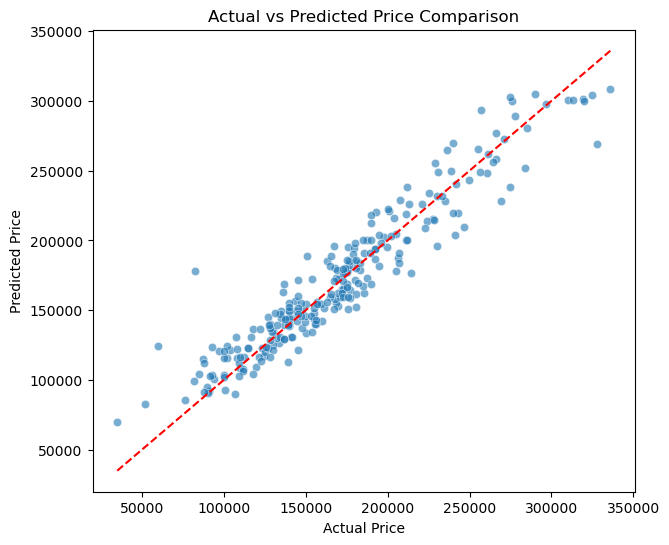

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))

# Scatter plot of actual vs predicted prices
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)

# Reference line y = x
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price Comparison")
plt.show()